In [379]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date 
from datetime import timedelta
from scipy import stats
import requests
import json


Data Set Information:

Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.


Attribute Information:

holiday Categorical US National holidays plus regional holiday, Minnesota State Fair
temp Numeric Average temp in kelvin
rain_1h Numeric Amount in mm of rain that occurred in the hour
snow_1h Numeric Amount in mm of snow that occurred in the hour
clouds_all Numeric Percentage of cloud cover
weather_main Categorical Short textual description of the current weather
weather_description Categorical Longer textual description of the current weather
date_time DateTime Hour of the data collected in local CST time
traffic_volume Numeric Hourly I-94 ATR 301 reported westbound traffic volume

In [380]:
df=pd.read_csv('C:\\Users\FURKAN\\Desktop\AWS\\Metro_Interstate_Traffic_Volume\\Metro_Interstate_Traffic_Volume.csv')

In [381]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [382]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [383]:
df.holiday=[1 if i!= 'None' else 0 for i in df.holiday]
df.holiday.value_counts()

0    48143
1       61
Name: holiday, dtype: int64

In [384]:
df.date_time=pd.to_datetime(df.date_time)
df.rename(columns={'date_time':'date'},inplace=True)
df.temp=[float(k-273.15) for k in df.temp]
df['time_interval']=df.date-df.date.shift(1)
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date,traffic_volume,time_interval
0,0,15.13,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,NaT
1,0,16.21,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,01:00:00
2,0,16.43,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,01:00:00
3,0,16.98,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,01:00:00
4,0,17.99,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,01:00:00


In [385]:
def intervals(df,day=False,hours=False,duplicates=False):
    if day:
       for i,interval in enumerate(df['time_interval']):
            if i !=0:
               day=interval.days
               if day >1:   
                   print('interval between two consecutive timestamps: {} days'.format(interval.days))
                   #print('i: ',i)
                   print(df.date[i-1])
                   print(df.date[i])
    if hours:
         interval_list=[]
         for i,interval in enumerate(df['time_interval']):
            if i !=0:
                hour=interval.seconds/3600
                if hour >=2: #
                    #print('interval between two consecutive timestamps: {} hours'.format(interval.seconds/3600))
                    #print('i: ',i)
                    interval_list.append(i)
         return interval_list
    if duplicates:
            duplicate=[]
            for i,interval in enumerate(df['time_interval']):
                if i !=0:
                    hour=interval.seconds/3600
                    if hour ==0: #
                        #print('interval between two consecutive timestamps: {} hours'.format(interval.seconds/3600))
                        #print('i: ',i)
                        duplicate.append(i)
            return duplicate

intervals(df,day=True)

interval between two consecutive timestamps: 10 days
2013-10-27 01:00:00
2013-11-06 04:00:00
interval between two consecutive timestamps: 4 days
2014-04-29 08:00:00
2014-05-04 05:00:00
interval between two consecutive timestamps: 2 days
2014-07-27 16:00:00
2014-07-30 09:00:00
interval between two consecutive timestamps: 307 days
2014-08-08 01:00:00
2015-06-11 20:00:00
interval between two consecutive timestamps: 4 days
2015-06-14 20:00:00
2015-06-19 18:00:00
interval between two consecutive timestamps: 3 days
2015-10-23 11:00:00
2015-10-27 08:00:00


No handles with labels found to put in legend.


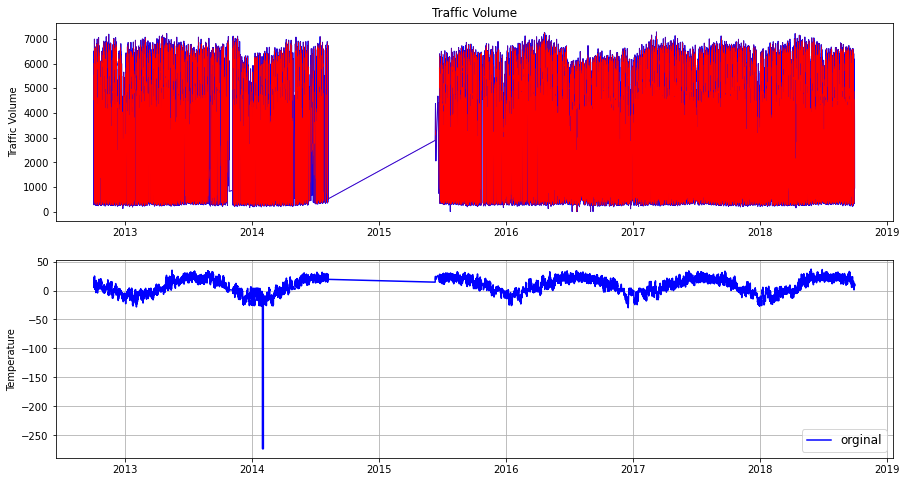

In [386]:
def plot_traffic(df):

    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    old_copy_traffic=df.traffic_volume.copy()
    df['traffic_volume']=np.where((df.traffic_volume==0),np.nan,df.traffic_volume,)
    ax[0].plot(df.date,old_copy_traffic.fillna(np.inf),color='blue',label='orginal',linewidth=1)
    ax[0].plot(df.date,df.traffic_volume.fillna(np.inf),color='red',label='modified',linewidth=0.2)
    
    ax[0].set_title('Traffic Volume')
    ax[0].set_ylabel('Traffic Volume')
    plt.legend(fontsize='large',loc='lower right')

    old_copy_temp=df.temp.copy()
    df['temp']=np.where((df.temp==0),np.nan,df.temp)
    ax[1].plot(df.date,old_copy_temp.fillna(np.inf),color='blue',label='orginal')
    
    ax[1].set_ylabel('Temperature')
    plt.grid()
    plt.legend(fontsize='large',loc='lower right')
    
    plt.show()
plot_traffic(df)

In [387]:
df=df[df.date > '2016-05'].reset_index(drop=True)
#df['weather_description']=df.weather_description.astype('category').cat.codes
df.drop(['rain_1h','snow_1h','weather_main','clouds_all','weather_description'],axis=1,inplace=True)
df.set_index('date',inplace=True)
df['date']=df.index
df.head()

,holiday,temp,traffic_volume,time_interval,date
date,,,,,
2016-05-01 01:00:00,0,6.87,946.0,01:00:00,2016-05-01 01:00:00
2016-05-01 02:00:00,0,6.33,735.0,01:00:00,2016-05-01 02:00:00
2016-05-01 03:00:00,0,5.87,395.0,01:00:00,2016-05-01 03:00:00
2016-05-01 04:00:00,0,5.41,390.0,01:00:00,2016-05-01 04:00:00
2016-05-01 05:00:00,0,5.03,629.0,01:00:00,2016-05-01 05:00:00


In [388]:
print(df.date[-1]-df.date[1])
print(len(df.index))
print(len(intervals(df,duplicates=True)))

882 days 21:00:00
25257
4217


In [389]:
df.drop_duplicates(subset='date',keep='first',inplace=True)
print(len(df.index))
print(len(intervals(df,duplicates=True)))
print('Number of intervals which are >= 2h : {}'.format(len(intervals(df,hours=True))))

21040
0
Number of intervals which are >= 2h : 111


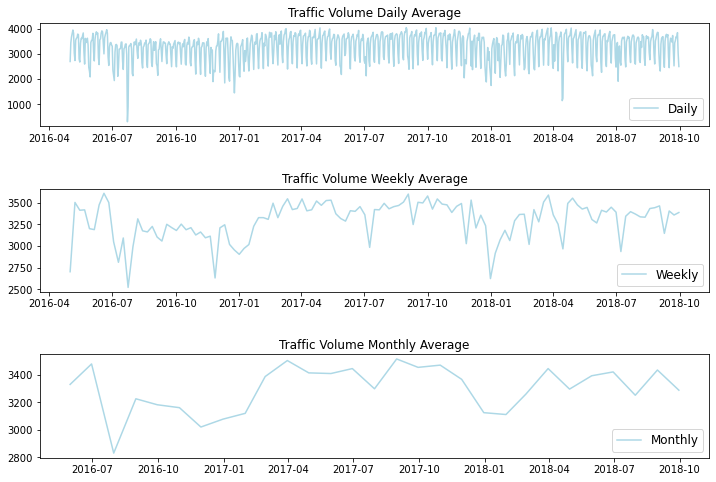

In [390]:
#resampled traffic volumes 

f, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
f.subplots_adjust(hspace=.6)
ax[0].plot(df.traffic_volume.resample('D').mean(),label='Daily',color='lightblue')  
ax[0].set_title('Traffic Volume Daily Average')
ax[0].legend(fontsize='large',loc='lower right')

ax[1].plot(df.traffic_volume.resample('W').mean(),label='Weekly',color='lightblue')  
ax[1].set_title('Traffic Volume Weekly Average')
ax[1].legend(fontsize='large',loc='lower right')
    

ax[2].plot(df.traffic_volume.resample('M').mean(),label='Monthly',color='lightblue')  
ax[2].set_title('Traffic Volume Monthly Average')
plt.legend(fontsize='large',loc='lower right')


plt.show()

In [391]:
#df['date']=df.index
#Downsampling 
resampled_traffic = df[['date','traffic_volume']].resample('D', on='date').sum().reset_index(drop=False )
resampled_holiday=df[['date','holiday']].resample('D',on='date').sum().reset_index(drop=False)
resampled_holiday.rename(columns={'date':'Date'},inplace=True)

resampled_temp=df[['date','temp']].resample('D',on='date').mean().reset_index(drop=False)
resampled_temp.rename(columns={'date':'Date'},inplace=True)

df1=pd.concat([resampled_traffic,resampled_temp,resampled_holiday],axis=1)
df1.drop(['Date'],axis=1,inplace=True)


df1["weekday"]=df1.apply(lambda row: row["date"].weekday(),axis=1)
df1["weekday"] = (df1["weekday"] < 5).astype(int)
df1.set_index('date')

dict_={0:'Weekend',1:'Weekday'}
df1['day'] = df1.weekday.map(dict_)


df1.head()


,date,traffic_volume,temp,holiday,weekday,day
0,2016-05-01,62211.0,10.607391,0,0,Weekend
1,2016-05-02,82915.0,11.594583,0,1,Weekday
2,2016-05-03,88410.0,14.824583,0,1,Weekday
3,2016-05-04,91614.0,12.977083,0,1,Weekday
4,2016-05-05,95033.0,15.141667,0,1,Weekday


No handles with labels found to put in legend.


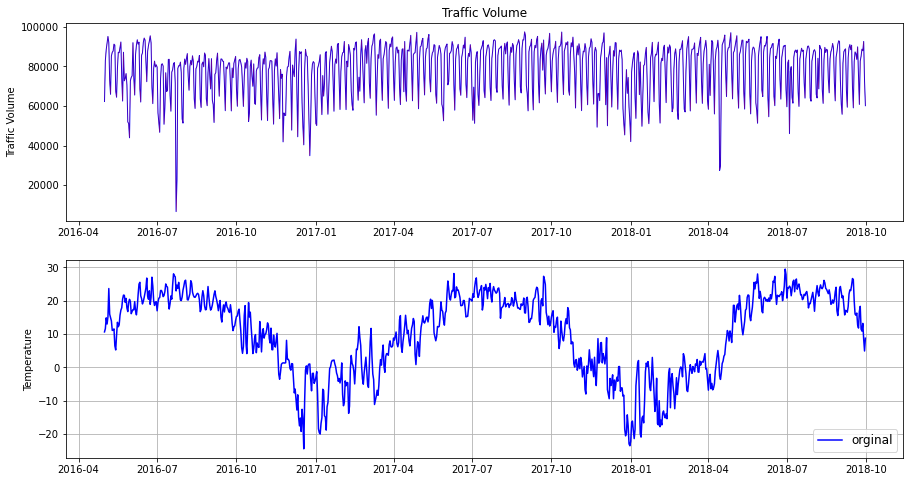

In [392]:
plot_traffic(df1)

No handles with labels found to put in legend.


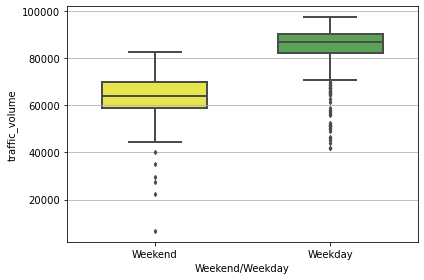

In [393]:


sns.boxplot(x='day',y='traffic_volume',width=0.6,fliersize=3,palette='Set1_r',data=df1,linewidth=2)                                                                                                                                                                                                                                                                                                                                                 
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
#sns.despine(left=True, bottom=True) 
plt.xlabel('Weekend/Weekday')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False)
plt.grid(which='major', axis='y')
plt.show()
df1.drop(['day'],axis=1,inplace=True)


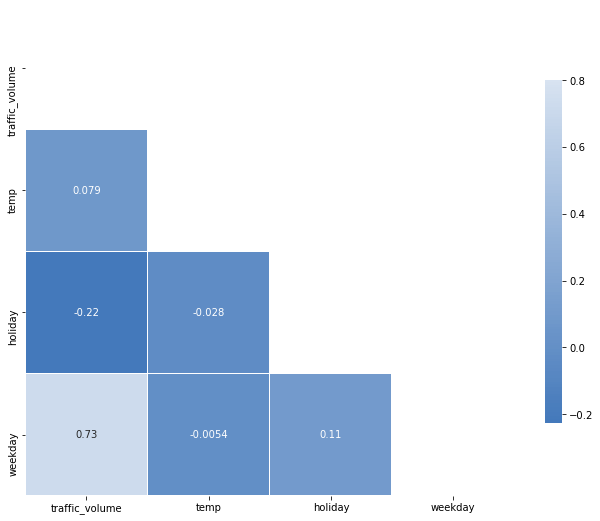

In [431]:
corr=df1.corr()

#sns.heatmap(corr,annot=True)

mask = np.triu(np.ones_like(corr))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(250, 50, as_cmap=True)

sns.heatmap(corr, mask=mask, annot=True,cmap=cmap, vmax=.8, center=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

plt.show()


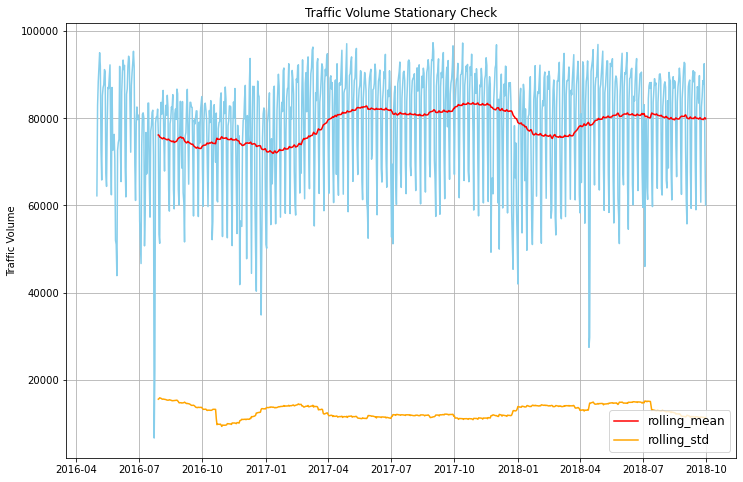

In [394]:
#Checking stationary status visually
rolling_window=90 # for 3 months based rolling window
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax.plot(df1.date,df1.traffic_volume,color='skyblue')
ax.plot(df1.date,df1.traffic_volume.rolling(rolling_window).mean(),color='red',label='rolling_mean')
ax.plot(df1.date,df1.traffic_volume.rolling(rolling_window).std(),color='orange',label='rolling_std')

ax.set_title('Traffic Volume Stationary Check')
ax.set_ylabel('Traffic Volume')
plt.grid()
plt.legend(fontsize='large',loc='lower right')
plt.show()

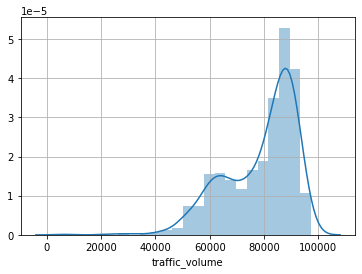

Skewness of normal distribution: -1.0646688605384333
Kurtosis of normal distribution: 1.0794893562348262


In [395]:
sns.distplot(df1.traffic_volume)
plt.grid()
plt.show()
print( 'Skewness of normal distribution: {}'.format(stats.skew(df1.traffic_volume)))
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df1.traffic_volume)))

In [396]:

from statsmodels.tsa.stattools import adfuller

result = adfuller(df1.traffic_volume.values)
adf_stat = result[0]
p_val = result[1]
crit_val_1 = result[4]['1%']
crit_val_5 = result[4]['5%']
crit_val_10 = result[4]['10%']

print('Test Statistic: {}'.format(result[0]),'p-value: {}'.format(result[1]),
'Critical Value_1: {}'.format(result[4]['1%']),'Critical Value_5: {}'.format(result[4]['5%']),
'Critical Value_10: {}'.format(result[4]['10%']),sep='\n')



Test Statistic: -3.7753040734202767
p-value: 0.0031703375775083
Critical Value_1: -3.4379677736185514
Critical Value_5: -2.8649026847264074
Critical Value_10: -2.568560548763626


In [432]:
freq='1D'

start_dataset=pd.Timestamp("2016-05-02 00:00:00",freq=freq)
end_training=pd.Timestamp("2017-09-13 00:00:00",freq=freq)#500
end_testing=pd.Timestamp("2018-06-20 00:00:00",freq=freq) #780


In [457]:

from pathlib import Path

if Path("C:\\Users\\FURKAN\\Desktop\\codes\\traffic_volume_train.json").is_file():
    print ("Train file already exist")
else:
    file = open("C:\\Users\\FURKAN\\Desktop\\codes\\traffic_volume_train.json", 'a+')
# One JSON sample per line
#line = "\"start\":\'{}'\,\"target\":{}\,\"cat\":{}".format(start_dataset, df1.iloc[:500,1].tolist(),df1.iloc[:500,4].tolist())
    train_data=json.dumps({
                'start':str(start_dataset),
                'target': df1.iloc[:500,1].tolist(),
                'dynamic_feat':[df1.iloc[:500,4].tolist()]
            })
    file.write(train_data)
    file.close()
    print('Train file has been created successfully')


if Path("C:\\Users\\FURKAN\\Desktop\\codes\\traffic_volume_test.json").is_file():
    print ("Test file already exist")
else:        
    file = open("C:\\Users\FURKAN\\Desktop\\codes\\traffic_volume_test.json", 'a+')

    test_data=json.dumps({
                'start':str(end_training),
                'target': df1.iloc[500:780,1].tolist(),
                'dynamic_feat':[df1.iloc[500:780,4].tolist()]
            })

    file.write(test_data)
    file.close()
    print('Test file has been created successfully')

if Path("C:\\Users\\FURKAN\\Desktop\\codes\\traffic_volume_samples.json").is_file():
    print ("Samples file already exist")
else:
    file = open("C:\\Users\\FURKAN\\Desktop\\codes\\traffic_volume_samples.json", 'a+')

    line=json.dumps({
                'start':str(end_testing),
                'target': df1.iloc[780:880,1].tolist(),
                'dynamic_feat':[df1.iloc[765:880,4].tolist()]
            })

    file.write(line)
    file.close()
    print('Samples file has been created successfully')

Train file already exist
Test file already exist
Samples file already exist


In [459]:
sample_data_list={
                'start':str(end_testing),
                'target': df1.iloc[700:880,1].tolist(),
                'dynamic_feat':[df1.iloc[700:880,4].tolist()]
            }

In [458]:
def get_prediction(data):
    url = 'url from API Gateway'
    r = requests.post(url, data=json.dumps(data))
    response = getattr(r,'_content').decode("utf-8")
    #print(response)
    return response


In [ ]:
prediction_mean = []
prediction_upper = []
prediction_lower = []
all_predictions_rmse=[]

for a in range(0,10):
    test_sample = {}
    test_sample = {"instances": [sample_data_list.copy()]}
    test_sample["instances"][0]["target"] = sample_data_list["target"][a+30:a+130]
    test_sample["instances"][0]["dynamic_feat"] = [sample_data_list["dynamic_feat"][0][a+30:a+145]]
    test_sample["configuration"] =  {"output_types": ["mean",
                                                      "quantiles"
                                                     ],
                                     "quantiles": ["0.1",
                                                   "0.9"
                                                  ]
                                    }
    #print(test_sample)
    
    prediction_upper.append(json.loads(get_prediction(test_sample))['body']['predictions'][0]['quantiles']['0.9'])
    prediction_mean.append(json.loads(get_prediction(test_sample))['body']['predictions'][0]['mean'])
    prediction_lower.append(json.loads(get_prediction(test_sample))['body']['predictions'][0]['quantiles']['0.1'])


for i in range(0,10):
         all_predictions_rmse.append(np.sqrt(np.mean(
             (np.array(prediction_mean[i]) - np.array(sample_data_list["target"][a+130:a+145]))**2)))


plt.plot(prediction_mean[9],'go--',label="predictions_mean",color='blue')
#plt.plot(prediction_upper[9], 'go-',label="upper level")
#plt.plot(prediction_lower[9],'go-', label="lower_level")
plt.plot(sample_data_list["target"][139:154], label="true value",color='red')
plt.fill_between(range(0,len(prediction_lower[9])),prediction_lower[9], prediction_upper[9], color='lightgreen', alpha=0.5, label='Confidence Interval')

#plt.axhspan(min(prediction_lower[9]),max(prediction_upper[9]),color="lightgreen",alpha=0.7)
plt.xlabel('Days')
plt.ylabel('Number of Traffic')
plt.title('15 Days Prediction with Dynamic Feature')
plt.ylim([30000,110000])
plt.xlim([0,15])
plt.grid()
plt.legend(loc='lower right')
plt.show()


print('RMSE (9) : ',np.sqrt(np.mean((np.array(prediction_mean[9]) - np.array(sample_data_list["target"][139:154]))**2)))
print('RMSE (low) : ',np.sqrt(np.mean((np.array(prediction_lower[9]) - np.array(sample_data_list["target"][139:154]))**2)))
print('RMSE (upp) : ',np.sqrt(np.mean((np.array(prediction_upper[9]) - np.array(sample_data_list["target"][139:154]))**2)))


plt.plot(all_predictions_rmse,color='orange')
plt.xlabel('Number of slides')
plt.ylabel('RMSE Score')
plt.title('RMSE Scores Per Window with Dynamic Feature')
plt.grid()
plt.show()

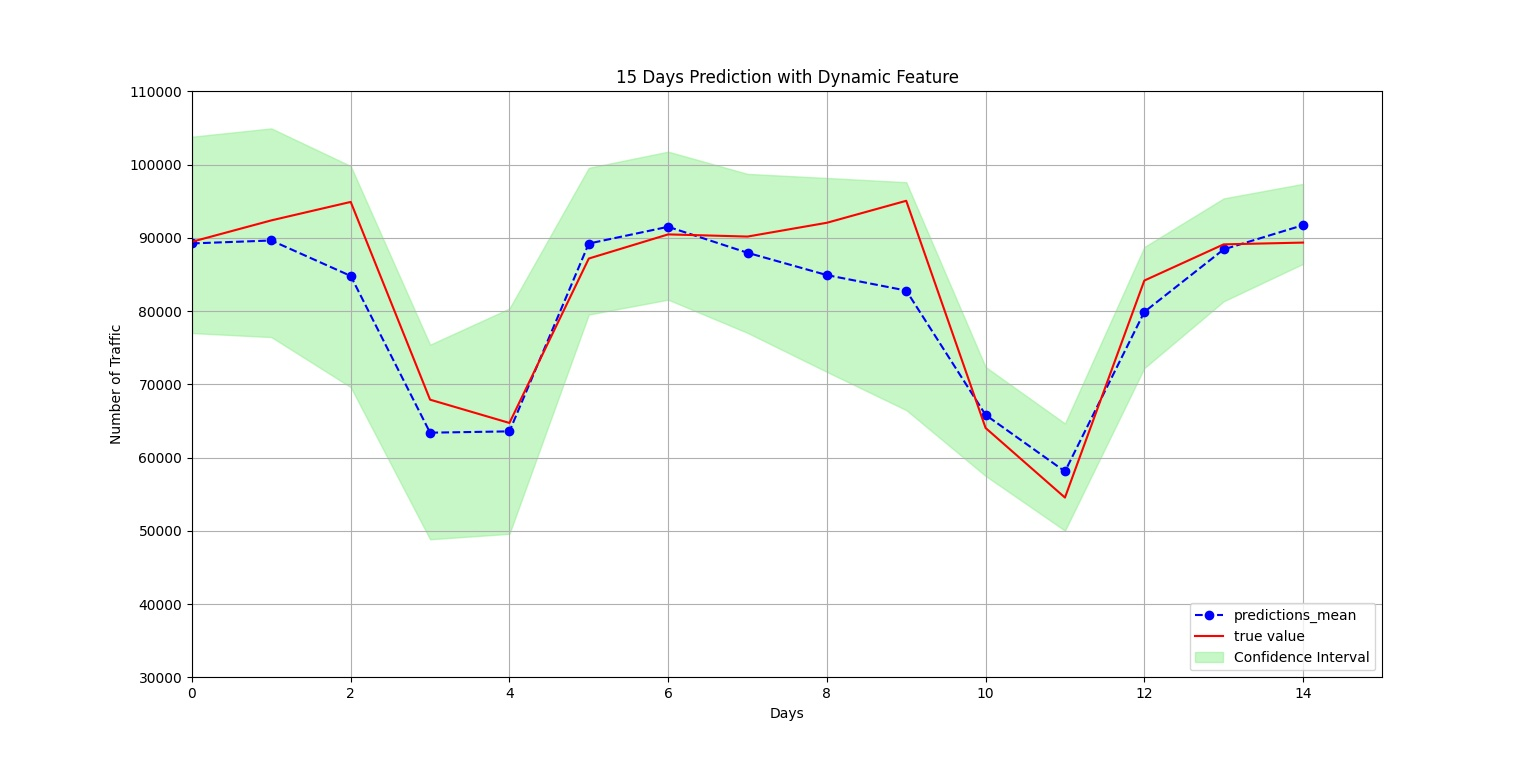



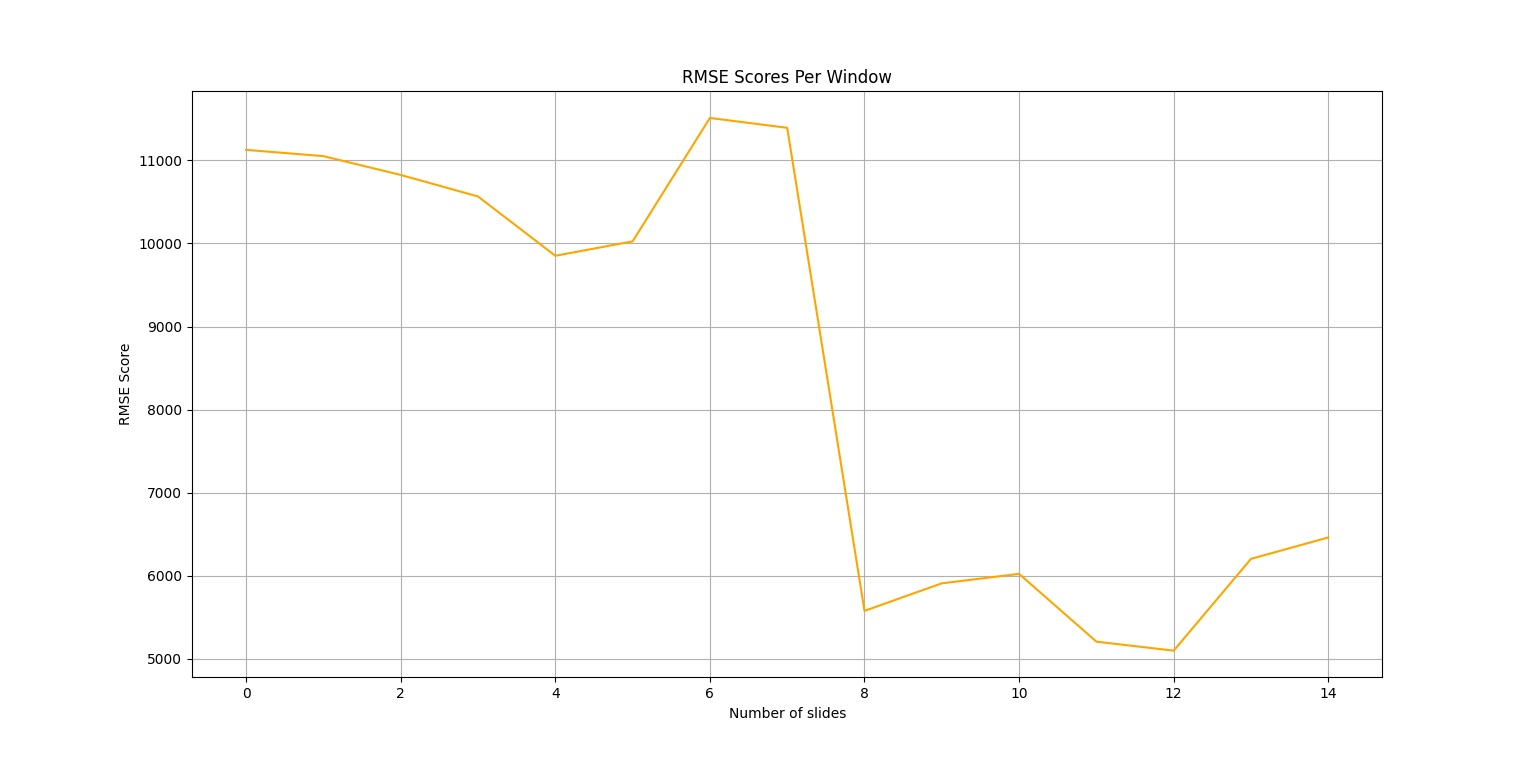


What if we don't provide dynamic feature to the model ?

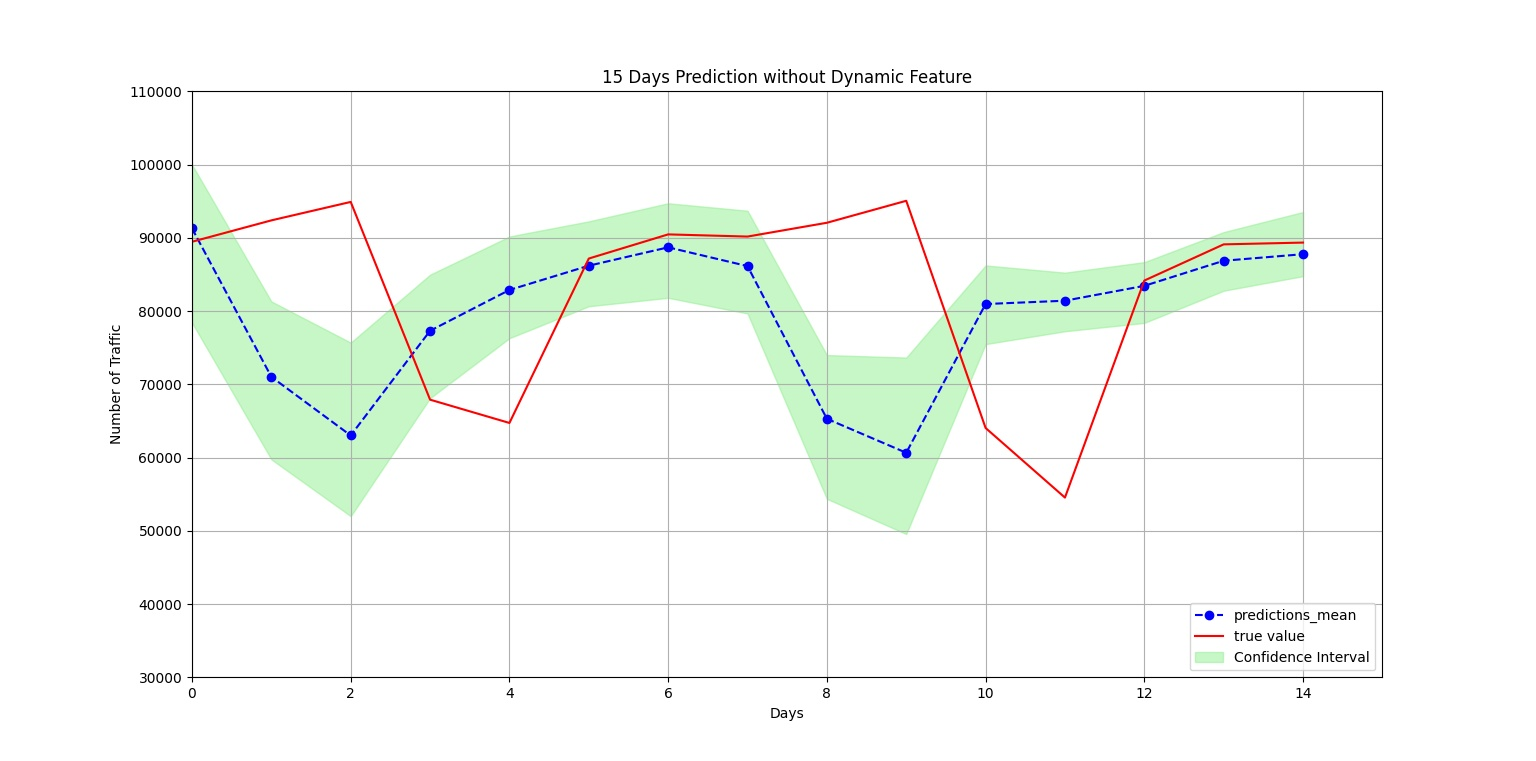

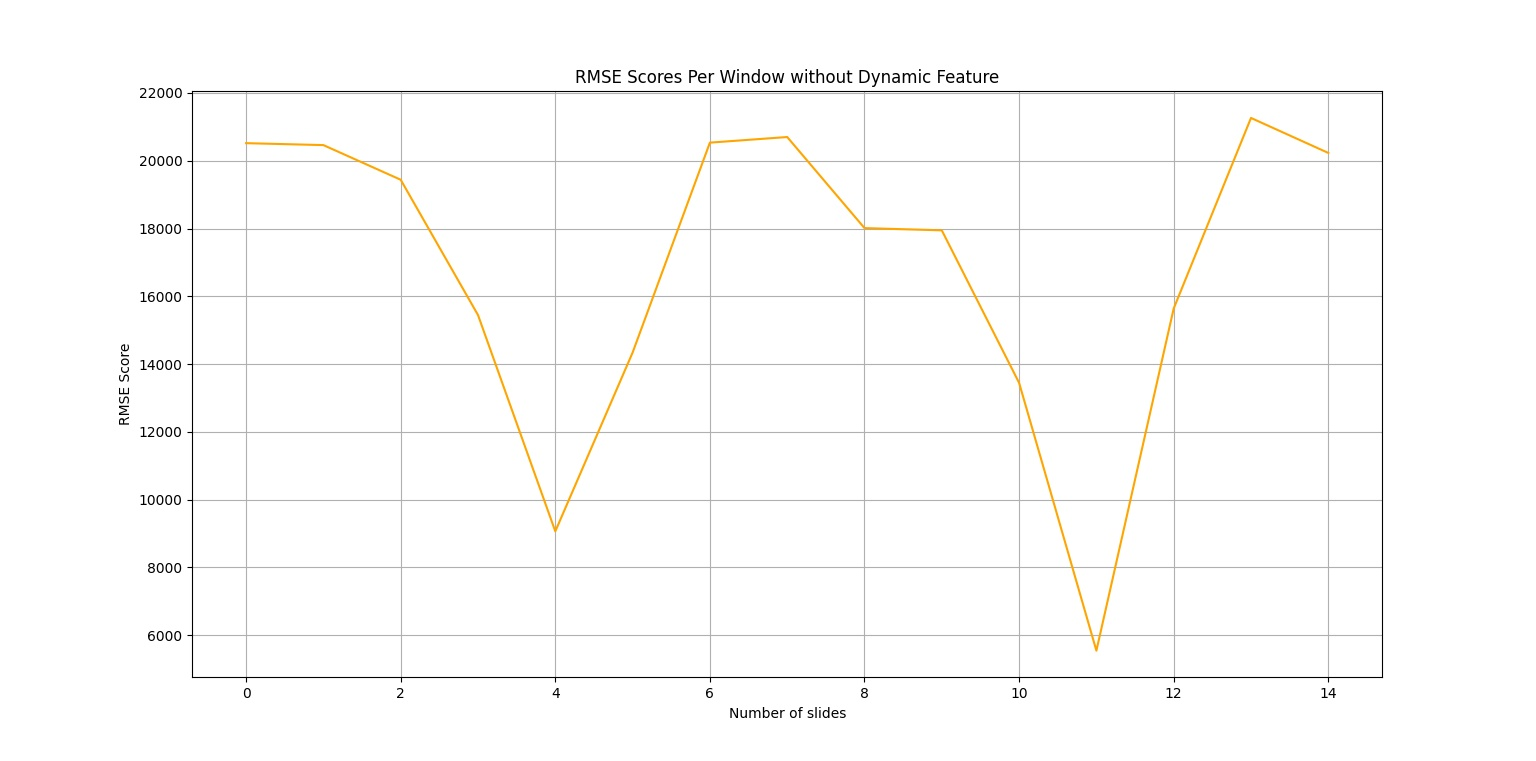

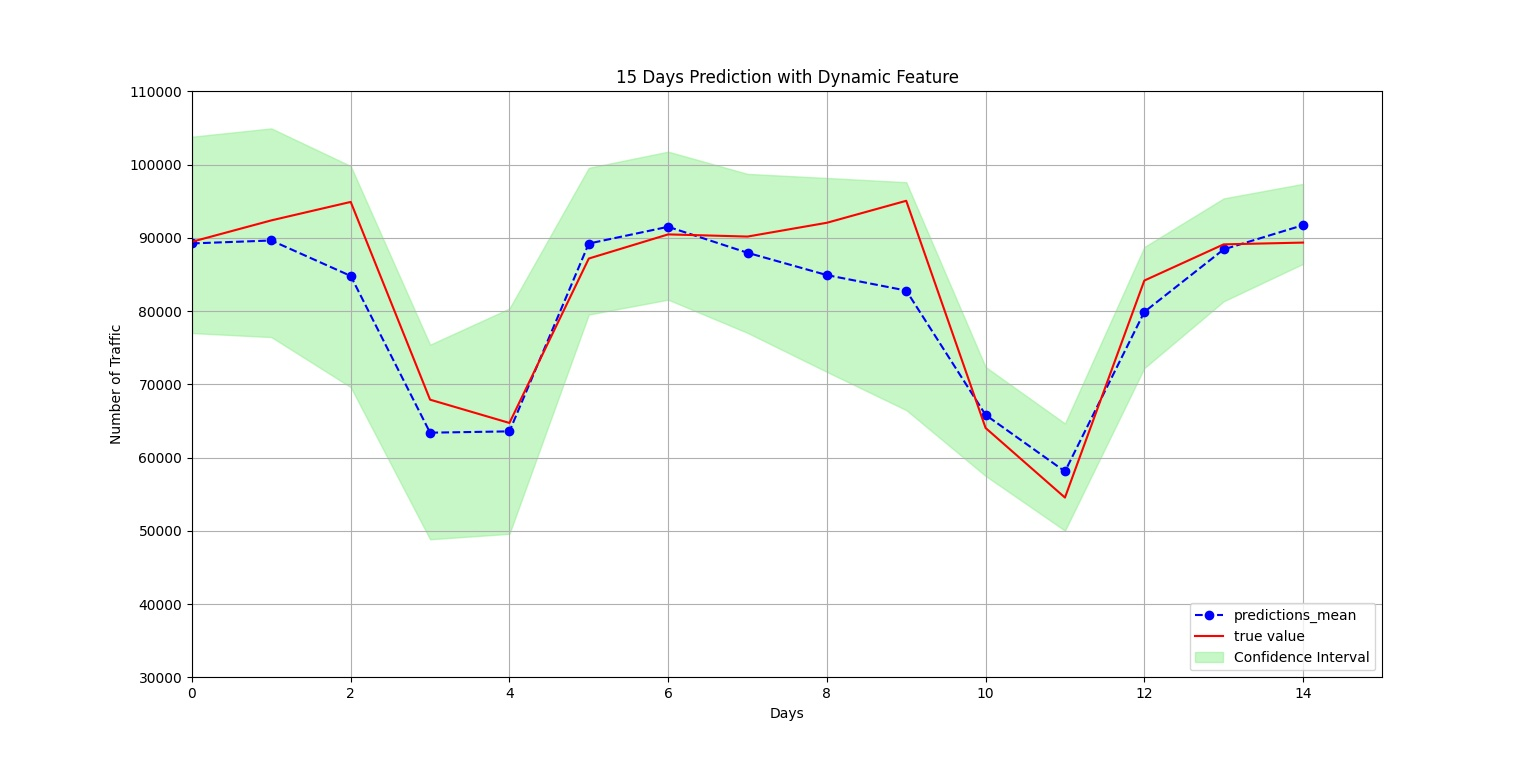

In [467]:

from IPython.display import Image

Image(filename = "C:\\Users\\FURKAN\\Desktop\\codes\\15 day prediction with dynamic feature.jpg", width = 500, height = 300)